<a href="https://colab.research.google.com/github/Mayurd9/NN-from-scratch/blob/main/Neural_network_generalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import joblib
import matplotlib.pyplot as plt

# **$\textbf{Loading Dataset}$**


In [ ]:
import tensorflow as tf
from keras.datasets import mnist

# Load the dataset
(x_train0, y_train), (x_test0, y_test) = mnist.load_data()
x_train = x_train0.reshape(x_train0.shape[0], -1)
x_test = x_test0.reshape(x_test0.shape[0], -1)

In [ ]:
x_train.shape

(60000, 784)

# **$\textbf{Required Functions}$**

In [ ]:
def sigmoid(z):
  return 1.0/(1.0+np.exp(-z))

def softmax(z):
  return np.exp(z)/np.sum(np.exp(z))

def feedforward(X, weights, biases, test, hl_activation, softmax_output):
  L=len(weights)+1
  a=[X]
  z=[]
  for k in range(L-1):
    z.append(weights[k]@a[k] + biases[k])
    if hl_activation=='sigmoid':
      a.append(sigmoid(z[k]))
    elif hl_activation=='tanh':
      a.append(2*sigmoid(2*z[k])-1)
    elif hl_activation=='ReLu':
      a.append(np.maximum(0,z[k]))
  if hl_activation=='tanh' or 'ReLu':
    a[-1]=sigmoid(z[-1])        #output layer is by default sigmoid since tanh and relu are not compatible with loss function
  if softmax_output==True:
    a[-1]=softmax(z[-1])

  if test==False:
    return a,z
  else:
    return a[-1]

def sigmoid_prime(z):
 return sigmoid(z)*(1-sigmoid(z))

def backprop(a,z,y,hl_activation,weights, cost, softmax_output):
  L=len(weights)+1
  if cost=='Quadratic':
    error=[(a[-1]-y)*sigmoid_prime(z[-1])]
  elif cost=='CrossEntropy' or softmax_output==True:
    error=[(a[-1]-y)]

  del_c_w_x=[error[-1]@a[-2].T]
  for l in range(2, L):
    if hl_activation=='sigmoid':
      activation_prime=sigmoid_prime(z[-l])
    elif hl_activation=='tanh':
      activation_prime = 4*sigmoid_prime(2*z[-l])
    elif hl_activation=='ReLu':
      activation_prime = np.absolute((np.absolute(z[-l])+z[-l])/(2*z[-l]))

    error.insert(0, (weights[-(l-1)].T @ error[-(l-1)])*activation_prime)
    del_c_w_x.insert(0, error[-l]@a[-l-1].T)

  del_c_b_x = error.copy()
  return del_c_b_x, del_c_w_x

# **$\textbf{Function for Training}$**

In [ ]:
def network_train(x_train,y_train,sizes,cost,hl_activation,epochs,eta,minibatch_size, regularization, lmbda, softmax_output):
  L= len(sizes)        #Total number of layers
  biases = [np.random.randn(y, 1) for y in sizes[1:]]
  weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(sizes[:-1], sizes[1:])]
  term_1 = 1
  term_2 = 0
  if regularization=='l2':
    term_1 = 1 - eta*lmbda/len(x_train)
    term_2 = 0
  elif regularization=='l1':
    term_1 = 1
    term_2 = (eta*lmbda/len(x_train))

  for epoch in range(epochs):
    print('epoch number', epoch)
    indices=np.arange(60000)
    np.random.shuffle(indices)
    for i in range(int(60000/minibatch_size)):
      minibatch_indices=indices[i*minibatch_size:(i+1)*minibatch_size]
      mini_batch_x = x_train[minibatch_indices]
      mini_batch_y = y_train[minibatch_indices]

      for j in range(len(mini_batch_x)):
        a, z = feedforward(mini_batch_x[j].reshape(-1,1)/255.0 , weights, biases, False, hl_activation, softmax_output)
        y= np.zeros((10,1))
        y[mini_batch_y[j]]=1
        del_c_b_x, del_c_w_x = backprop(a,z,y,hl_activation, weights, cost, softmax_output)

        if j==0:
          del_c_b = del_c_b_x.copy()
          del_c_w = del_c_w_x.copy()
        else:
          for m in range(len(del_c_b)):
            del_c_b[m] += del_c_b_x[m]
            del_c_w[m] += del_c_w_x[m]

      #weights and biases update using stochastic gradient descent
      for n in range(L-1):
        weights[n] = term_1*weights[n] - term_2*np.sign(weights[n]) - (eta/minibatch_size)*del_c_w[n]
        biases[n] = biases[n] - (eta/minibatch_size)*del_c_b[n]

  import joblib
  file_path1 = 'weights.joblib'
  file_path2 = 'biases.joblib'
  joblib.dump(weights , file_path1)
  joblib.dump(biases , file_path2)

  return weights, biases

# **$\textbf{Function for Testing}$**

In [ ]:
def network_test(X_test, y_test, weights, biases, hl_activation, softmax_output):
  L=len(weights)+1
  c=0
  for o in range(len(x_test)):
    pred_label = np.argmax(feedforward(x_test[o].reshape(-1,1)/255.0, weights, biases, True,hl_activation,softmax_output))
    if pred_label == y_test[o]:
      c+=1
  accuracy=100*c/len(x_test)
  print('Accuracy=',accuracy)
  return accuracy

# $\textbf{Training}$

$\textbf{Available Options (Type the text as given below while giving inputs as arguments for calling the function):}$

$\text{1) Hidden layer activation function: sigmoid, tanh, ReLu (default output activation in sigmoid)}$

$\text{2) Output activation function: sigmoid (default), softmax (Boolean: True/False)}$

$\text{3) Cost(Loss function): Quadratic, CrossEntropy}$

$\text{4) Regularization: l1, l2}$

In [ ]:
weights, biases = network_train(x_train,y_train,sizes= [784,30,10], cost='CrossEntropy',hl_activation='sigmoid', epochs=30 ,eta=0.5 ,minibatch_size=10, regularization='l2', lmbda= 6.0, softmax_output=False)

epoch number 0
epoch number 1
epoch number 2
epoch number 3
epoch number 4
epoch number 5
epoch number 6
epoch number 7
epoch number 8
epoch number 9
epoch number 10
epoch number 11
epoch number 12
epoch number 13
epoch number 14
epoch number 15
epoch number 16
epoch number 17
epoch number 18
epoch number 19
epoch number 20
epoch number 21
epoch number 22
epoch number 23
epoch number 24
epoch number 25
epoch number 26
epoch number 27
epoch number 28
epoch number 29


# **$\textbf{Testing}$**

In [ ]:
import joblib
weights= joblib.load('weights.joblib')
biases= joblib.load('biases.joblib')

In [ ]:
network_test(x_test, y_test, weights, biases, hl_activation='sigmoid', softmax_output=False)

Accuracy= 96.09


96.09

# **$\textbf{Testing on Random Image}$**

Predicted label =  6


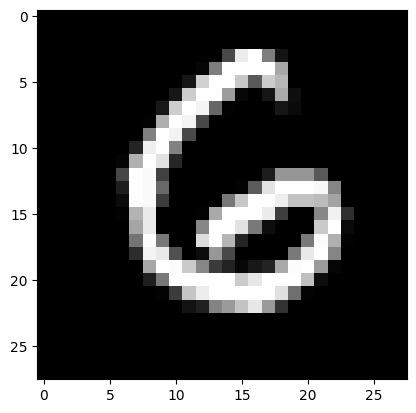

In [ ]:
random_index= np.random.randint(10000)
plt.imshow(x_test0[random_index], cmap= 'gray')

pred_label = np.argmax(feedforward(x_test0[random_index].reshape(-1,1)/255.0, weights, biases, test= True, hl_activation='sigmoid',softmax_output=False))
print('Predicted label = ', pred_label)